In [1]:
from glob import glob
from os.path import basename

import numpy as np
import CONAN3

##### ------------------------------------

The CONAN3 has 3 major classes that are used to store the load and store information about the input files and also perform computations.

They are:
- `load_lightcurves` : ingest lightcurve files and creates an object that is used to configure baseline and model parameters 
- `load_rvs` : same as above but for rvs
- `setup_fit` : object to configure fit

These objects are then given as input to the `fit_data` function to perform sampling. 

Example

### light curve object

In [2]:
path = "/home/tunde/Dropbox/postdoc/work/wasp-12/WASP-12_1201-10212/pipe_lcs/"
lcs = sorted(glob(f"{path}w12*"))
lc_list = [basename(lc) for lc in lcs[:4]]

print(lc_list)

['w12_lc01p.dat', 'w12_lc02p.dat', 'w12_lc03p.dat', 'w12_lc04p.dat']


In [3]:
lc_data = CONAN3.load_lightcurves(lc_list, path, filters = "CH", lamdas=6000)
lc_data

Filters: ['CH', 'CH', 'CH', 'CH']
Order of unique filters: ['CH']


Object containing 4 lightcurves
Files:['w12_lc01p.dat', 'w12_lc02p.dat', 'w12_lc03p.dat', 'w12_lc04p.dat']
Filepath: /home/tunde/Dropbox/postdoc/work/wasp-12/WASP-12_1201-10212/pipe_lcs/

- The lc_data object holds information now about the light curves. The light curves can be plotted using the `plot` method of the object.

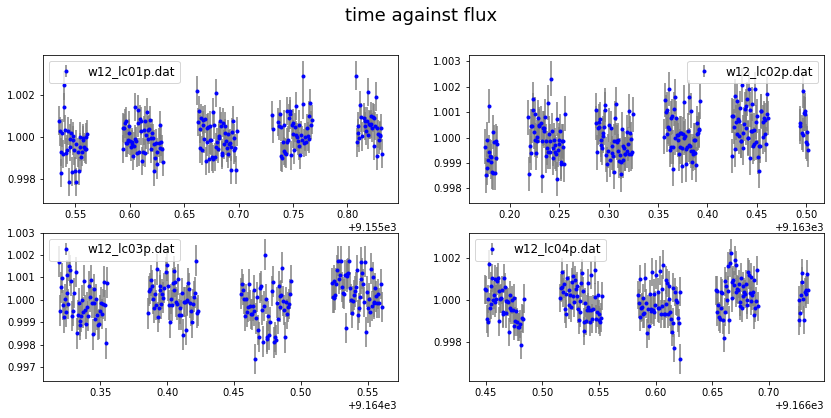

In [4]:
lc_data.plot()

- correlations between the flux and other columns in the lightcurve file can be visualized by specifying the columns to plot. e.g. to plot column5 (roll angle) against column 1 (flux)

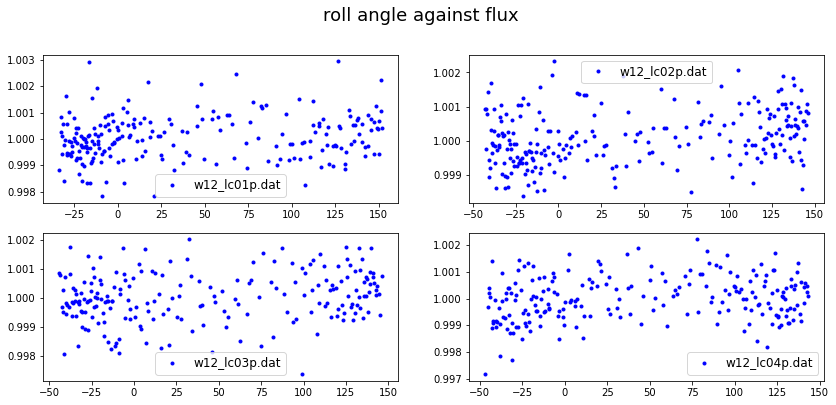

In [5]:
lc_data.plot(plot_cols=(5,1), col_labels=("roll angle","flux"))

- the baseline model for each lightcurve in the lc_data object can be defined using the `lc_baseline` 

the polynomial order for the cotrending vectors (t, x, y, phi, conta, bg/sky...) is specified for each lightcurve (lc) in lc_data. A list of equal to number of lcs is expected. if a single integer is given, the same is used for all lcs. "y" or "n" can be used to specify if an lc baseline should include a gp.

Error reporting will help catch most mistakes :)

*(t, x, y, phi, conta, bg/sky...)  correspond to columns of the input data --> columns 0, 3 4,5,6,7 respectively. Any desired array can be put in these columns to decorrelate against them irrespective of the name here (which would be modified soon)



In [6]:
lc_data.lc_baseline(dt = [1,0,0,1], dy=0, dx=1, gp=["y","n"]*2)

#---------------------------------------------------
# Input lightcurves filters baseline function
name           	fil	 lamda	 time	 roll	 x	 y	 conta	 sky	 sin	 group	 id	 GP
w12_lc01p.dat  	CH 	6000.0	    1	   0	 1	 0	     0	   0	   0	     0	  1	 y 
w12_lc02p.dat  	CH 	6000.0	    0	   0	 1	 0	     0	   0	   0	     0	  2	 n 
w12_lc03p.dat  	CH 	6000.0	    0	   0	 1	 0	     0	   0	   0	     0	  3	 y 
w12_lc04p.dat  	CH 	6000.0	    1	   0	 1	 0	     0	   0	   0	     0	  4	 n 


In [7]:
gp_lcs = list(lc_data._gp_lcs)
gp_lcs

['w12_lc01p.dat', 'w12_lc03p.dat']

- add GPs to specified lcs. only lcs with GP = 'y' above can be included.

the independent variable of the gp can be any of ["time", "xshift", "yshift", "air", "fwhm", "sky"] again corresponding to columns of the input data --> columns 0, 3 4,5,6,7. to be changed soon 

the `pars` argument specifies the independent gp variable for each lc by taking a list of strings from the options above. if  single string is given, same independent variable is used for all specified lcs. To apply a two dimensional GP on an lc, the file name must be given twice and the corresponding `pars` value will specify the variable of the different dimensions.

similarly `kernels` argument specifies the kernel for each specified lc

The `log_scale` and `log_metric` arguments specify the prior of the variance and lengthscale of the GP kernel applied for each specified lc. It is given as follows:
* if tuple is of len 2, set normal prior with index[0] as prior mean and index[1] as prior width.
* if tuple is of len 3, set uniform prior with between index[0] and index[2], index[1] is the initial value.

if a single tuple is given, same prior is used for all specified lcs


To apply a 2D GP to the first lc and 1D to the third:

In [8]:
gp_list = ['w12_lc01p.dat'] +gp_lcs
gp_list

['w12_lc01p.dat', 'w12_lc01p.dat', 'w12_lc03p.dat']

In [9]:
lc_data.add_GP(lc_list = gp_list,
               pars = ["air","time","air"],
               kernels = ["mat32","sqexp","mat32"],
               log_scale = (-25,-17,0),
               log_metric = [(0,20), (-15,0),(0,20)],
               verbose = True)

# -------- photometry GP input properties: komplex kernel -> several lines --------------
name          para  kernel WN scale   s_step s_pri s_pri_wid s_up  s_lo  metric  m_step m_pri  m_pri_wid m_up m_lo
w12_lc01p.dat air   mat32  y  4.1e-08 0.0010 -17.0  0.00e+00  0.0 -25.0 1.0e+00 0.0010  0.00  2.00e+01 10.0 -10.0
w12_lc01p.dat time  sqexp  y  4.1e-08 0.0010 -17.0  0.00e+00  0.0 -25.0 3.1e-07 0.0010 -15.00  0.00e+00 -5.0 -25.0
w12_lc03p.dat air   mat32  y  4.1e-08 0.0010 -17.0  0.00e+00  0.0 -25.0 1.0e+00 0.0010  0.00  2.00e+01 10.0 -10.0


### Transit parameters

The model paramters are: ['RpRs', 'Impact_para', 'Duration', 'T_0', 'Period', 'Eccentricity', 'Omega', 'K']

The parameters can be defined in following ways:

* fixed value as float or int, e.g Period = 3.4
* free parameter with gaussian prior given as tuple of len 2, e.g. T_0 = (5678, 0.1)
* free parameters with uniform prior interval and initial value given as tuple of length 3, e.g. RpRs = (0,0.1,0.2) with 0.1 being the initial value.

In [10]:
lc_data.setup_transit_rv(RpRs = (0,0.1,0.2),
                        Impact_para = 0.3,
                        T_0 = (0.,0.01))

#=========== jump parameters (Jump0value step lower_limit upper_limit priors) ======================
name        	fit	start_val	stepsize	low_lim	up_lim	prior	value	sig_lo	sig_hi
RpRs        	y  	 0.10000	0.0020000	0.00	0.20	n	0.10000	0.0e+00	0.0e+00 
Impact_para 	n  	 0.30000	0.0000000	0.00	1.00	n	0.30000	0.0e+00	0.0e+00 
Duration    	n  	 0.12450	0.0000000	0.00	1.00	n	0.12450	0.0e+00	0.0e+00 
T_0         	y  	 0.00000	0.0001000	0.00	10000.00	p	0.00000	1.0e-02	1.0e-02 
Period      	n  	 3.00000	0.0000000	0.00	10000.00	n	3.00000	0.0e+00	0.0e+00 
Eccentricity	n  	 0.00000	0.0000000	0.00	1.00	n	0.00000	0.0e+00	0.0e+00 
Omega       	n  	90.00000	0.0000000	0.00	360.00	n	90.00000	0.0e+00	0.0e+00 
K           	n  	 0.00000	0.0000000	0.00	10000.00	n	0.00000	0.0e+00	0.0e+00 


In [11]:
#time, flux, err, xshift, yshift, roll, thermfront2, bg, exp

#### optioanl configurations

In [12]:
lc_data.transit_depth_variation()

#=========== ddF setup ==============================================================================
Fit_ddFs  step	 low_lim   up_lim   prior   sig_lo   sig_hi   div_white
n         0.001	 -1.0000   1.0000   n       0.00000   0.00000   n  
group_ID   RpRs_0   err		dwfile
     1	   0.1000   1.00e-04   dw_001.dat
     2	   0.1000   1.00e-04   dw_002.dat
     3	   0.1000   1.00e-04   dw_003.dat
     4	   0.1000   1.00e-04   dw_004.dat


In [13]:
lc_data.setup_occultation("all")

fitting occultation depth for filters: ['CH']

#=========== occultation setup =============================================================================
filters	fit start_val	stepsize  low_lim  up_lim  prior  value      sig_lo 	sig_hi 
CH     	y   0.00050000	0.0000100    0.000   0.001  n      0.000e+00  0.00e+00	0.00e+00 


In [14]:
lc_data.limb_darkening(c1=(0,1.5,2))

#=========== Limb darkending setup ===================================================================
filters priors	c_1  step1  low_lim1  up_lim1	c_2  step2 low_lim2 up_lim2
CH      n     	1.500 0.001  0.0000  2.0000	0.000 0.001  0.0000  0.0000


In [15]:
lc_data.contamination_factors()

#=========== contamination setup === give contamination as flux ratio ================================
filters	contam	err
CH     	0.0000	0.0000


### RV data if available

In [18]:
# rvs= sorted(glob(f"{path}rv*"))
# rv_list = [basename(rv) for rv in rvs]
# print(rv_list)

['rv1.dat', 'rv2.dat']


In [31]:
rv_data= CONAN3.load_rvs()
rv_data

Object containing 0 rvs
Files:[]
Filepath: /home/tunde/Dropbox/postdoc/work/CONAN3

In [32]:
rv_data.plot()

No data to plot


In [33]:
rv_data.rv_baseline()

# --------------------------------------------------------------
# Input RV curves, baseline function, gamma
name            time  bis  fwhm  contrast  gamma_kms  stepsize  prior  value  sig_lo  sig_hi


### object to setup fit

In [34]:
fitter = CONAN3.setup_fit()
fitter

In [35]:
fitter.stellar_parameters((1,0.1,0),(1,0.1,0.2),"MR")

#=========== Stellar input properties ================================================================
# parameter    value  sig_lo  sig_hi
Radius_[Rsun]  1.000  0.100  0.000
Mass_[Msun]    1.000  0.100  0.200
Stellar_para_input_method:_R+rho_(Rrho),_M+rho_(Mrho),_M+R_(MR): MR


In [36]:
fitter.mcmc_setup()

#=========== MCMC setup ==============================================================================
Total_no_steps           128000
Number_chains            64
Number_of_processes      2
Burnin_length            500
Walk_(snooker/demc/mrw)  None
GR_test_(y/n)            y
Make_plots_(y/n)         n
leastsq_(y/n)            y
Savefile                 output_ex1.npy
Savemodel                n
Adapt_base_stepsize      y
Remove_param_for_CNM     n
leastsq_for_basepar      n
lssq_use_Lev-Marq        n
apply_CFs                y
apply_jitter             y


- create a config file from defined parameters

In [25]:
CONAN3.create_configfile(lc_data, rv_data, fitter,
                         filename='input_config.dat')

#### finally fit using the 3 objects

In [37]:
CONAN3.fit_data(lc_data, rv_data, fitter)

IndexError: list index out of range